# Importar librerías

In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm

# Importar repositorio

In [2]:
!git --version
!git clone https://github.com/AdityaLab/pinnsformer.git
%cd pinnsformer

git version 2.34.1
Cloning into 'pinnsformer'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 139 (delta 42), reused 4 (delta 0), pack-reused 0
Receiving objects: 100% (139/139), 24.77 MiB | 11.18 MiB/s, done.
Resolving deltas: 100% (42/42), done.
/content/pinnsformer


In [3]:
from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

# Configuraciones

In [4]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

beta=3

# Mesh inicial

In [5]:
n_train=51
n_test=101

res, b_left, b_right, b_upper, b_lower = get_data([0,1], [0,1], n_train, n_train)
res_test, _, _, _, _ = get_data([0,1], [0,1], n_test, n_test)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

# Instanciar el modelo

In [6]:
# Train PINNs

model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters(), lr=1e-4)

n_params = get_n_params(model)

print(model)
print(get_n_params(model))

<ipython-input-5-9238d78375f4>:21: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


# Sistema físico

## Ecuación diferencial

## Condiciones de contorno (frontera)

## Condiciones iniciales

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


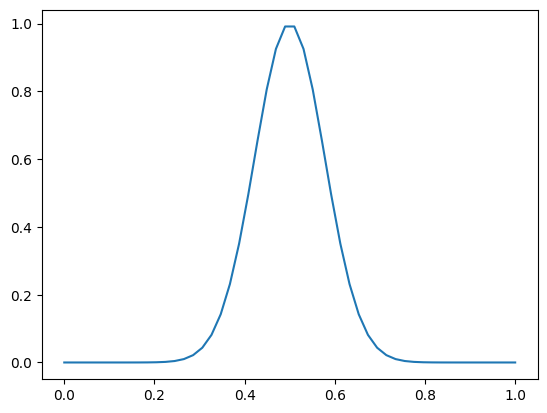

In [7]:
mu = 0.5
sigma = 0.08
k = np.pi
def u_t0(x):
  return np.exp(-0.5*((x-mu)/sigma)**2)*np.exp(1j*k*(x-mu))

x = np.linspace(0,1)
plt.plot(x,u_t0(x))


# Entrenar el modelo

In [8]:
ti = time.time()
loss_track = []

mu = 0.5
sigma = 0.01
k = np.pi


def conj(tensor):
    # Mover el tensor a la CPU si está en la GPU
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # Convertir el tensor a un array de NumPy y calcular el conjugado
    numpy_conj = np.conjugate(tensor.detach().numpy())

    # Convertir el array de NumPy de vuelta a un tensor de PyTorch
    return torch.from_numpy(numpy_conj).to(device)

for i in tqdm(range(10)):
    def closure():
        pred_res = model(x_res, t_res)
        pred_left = model(x_left, t_left)
        pred_right = model(x_right, t_right)
        pred_upper = model(x_upper, t_upper)
        pred_lower = model(x_lower, t_lower)

        # Calcular elementos de PDE
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]

        # PDE
        loss_res = torch.mean((u_xx + 1j*u_t) * conj(u_xx + 1j*u_t)).real


        # Condiciones de contorno: limites u = 0
        loss_bc = torch.mean(pred_upper * conj(pred_upper)) + torch.mean(pred_lower * conj(pred_lower)).real


        # Condiciones iniciales -> funcion de onda inicial pulso gaussiano
        loss_ic = torch.mean((pred_left[:,0] - torch.exp(-0.5*((x_left[:,0]-0.5)/sigma)**2) * torch.exp(1j*k*(x_left[:,0]-0.5))) *
                         conj(pred_left[:,0] - torch.exp(-0.5*((x_left[:,0]-0.5)/sigma)**2) * torch.exp(1j*k*(x_left[:,0]-0.5)))).real


        loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])

        loss = loss_res + loss_ic + loss_bc
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

tf = time.time()

print()
print("Entrenamiento:", round(tf-ti))

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 10/10 [00:04<00:00,  2.11it/s]


Entrenamiento: 5


In [9]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dwave_pinns.pt')

Loss Res: 0.000052, Loss_BC: 0.019892, Loss_IC: 0.000105
Train Loss: 0.020049


Entrenamiento: 0
relative L1 error: 0.999960
relative L2 error: 0.999341


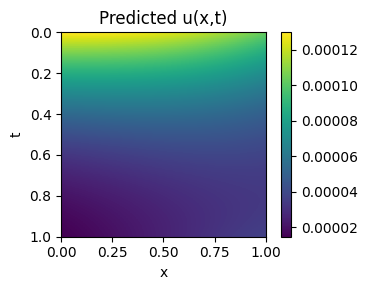

In [10]:
# Visualize PINNs
ti = time.time()

res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(n_test,n_test)

tf = time.time()

print("Entrenamiento:", round(tf-ti))

def u_ana(x,t):
    return np.sin(np.pi*x) * np.cos(2*np.pi*t) + 0.5 * np.sin(beta*np.pi*x) * np.cos(6*np.pi*t)

res_test, _, _, _, _ = get_data([0,1], [0,1], n_test, n_test)
u = u_ana(res_test[:,0], res_test[:,1]).reshape(n_test,n_test)

rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow((pred*np.conjugate(pred)), extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinns_pred.png')
plt.show()

In [13]:
pred

array([[0.01138679, 0.0113863 , 0.01138572, ..., 0.01018107, 0.01015064,
        0.0101197 ],
       [0.01127686, 0.01127642, 0.01127587, ..., 0.01008721, 0.01005714,
        0.01002654],
       [0.01116721, 0.01116681, 0.0111663 , ..., 0.0099942 , 0.00996434,
        0.00993407],
       ...,
       [0.00389351, 0.00391515, 0.00393704, ..., 0.00600271, 0.00601745,
        0.00603155],
       [0.00387046, 0.00389249, 0.00391463, ..., 0.00602899, 0.00604431,
        0.00605927],
       [0.00384851, 0.00387113, 0.00389365, ..., 0.00605716, 0.00607299,
        0.00608854]], dtype=float32)

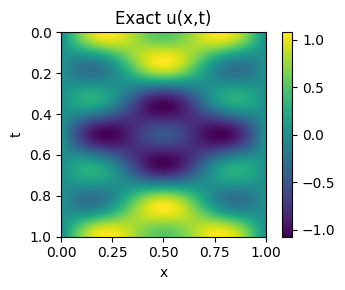

In [11]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_exact.png')
plt.show()

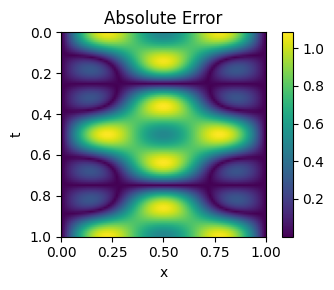

In [12]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,1,1,0])
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dwave_pinns_error.png')
plt.show()